# Quicklook Map Example


### Load in the libraries that we'll use below:

In [185]:
import sys
from os.path import *
import os

from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

from pylab import figure, cm


import astropy.time
import astropy.units as u
from astropy.coordinates import get_sun

import sunpy.map
from sunpy import sun

import numpy as np
%matplotlib inline



### Load in the data

In [186]:
infile = 'data/Sol_16208/20201001001/event_cl/nu20201001001A06_chu12_N_cl_sunpos.evt'

In [188]:
hdulist = fits.open(infile)

evtdata=hdulist[1].data
hdr = hdulist[1].header

print("Loaded: ", len(evtdata['X']), " counts.")
print("Effective exposure: ", hdr['EXPOSURE'], ' seconds')
hdulist.close()

Loaded:  728843  counts.
Effective exposure:  30.8255227372596  seconds


/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: ResourceWarning: unclosed file <_io.FileIO name='data/Sol_16208/20201001001/event_cl/nu20201001001A06_chu12_N_cl_sunpos.evt' mode='rb' closefd=True>
  if __name__ == '__main__':


### Do some quick filtering

In [91]:
energy_low = 2.5
energy_high = 10.
pilow = (energy_low - 1.6) / 0.04
pihigh = (energy_high - 1.60) /  0.04

# Grade filter
grade_filter = ( evtdata['GRADE'] == 0)
pi_filter = ( ( evtdata['PI']>pilow ) &  ( evtdata['PI']<pihigh))

# Hot pixel filters:
# FPMA or FPMB
if infile.find('B06') == -1 :
    print("Filtering bad pixels for FPMA.")
    pix_filter = np.invert( ( (evtdata['DET_ID'] == 2) & (evtdata['RAWX'] == 16) & (evtdata['RAWY'] == 5) |
                            (evtdata['DET_ID'] == 2) & (evtdata['RAWX'] == 24) & (evtdata['RAWY'] == 22) |
                            (evtdata['DET_ID'] == 2) & (evtdata['RAWX'] == 27) & (evtdata['RAWY'] == 6) |
                            (evtdata['DET_ID'] == 2) & (evtdata['RAWX'] == 27) & (evtdata['RAWY'] == 21) |
                            (evtdata['DET_ID'] == 3) & (evtdata['RAWX'] == 22) & (evtdata['RAWY'] == 1) |
                            (evtdata['DET_ID'] == 3) & (evtdata['RAWX'] == 15) & (evtdata['RAWY'] == 3) |
                            (evtdata['DET_ID'] == 3) & (evtdata['RAWX'] == 5) & (evtdata['RAWY'] == 5) | 
                            (evtdata['DET_ID'] == 3) & (evtdata['RAWX'] == 22) & (evtdata['RAWY'] == 7) | 
                            (evtdata['DET_ID'] == 3) & (evtdata['RAWX'] == 16) & (evtdata['RAWY'] == 11) | 
                            (evtdata['DET_ID'] == 3) & (evtdata['RAWX'] == 18) & (evtdata['RAWY'] == 3) | 
                            (evtdata['DET_ID'] == 3) & (evtdata['RAWX'] == 24) & (evtdata['RAWY'] == 4) | 
                            (evtdata['DET_ID'] == 3) & (evtdata['RAWX'] == 25) & (evtdata['RAWY'] == 5) ) )



else:
    print("Filtering bad pixels for FPMB.")
    pix_filter = np.invert( ( (evtdata['DET_ID'] == 0) & (evtdata['RAWX'] == 24) & (evtdata['RAWY'] == 24)) )


inds = (grade_filter & pi_filter & pix_filter).nonzero()
goodinds=inds[0]

print("Found: ", len(goodinds), " good counts.")






Filtering bad pixels for FPMA.
Found:  294285  good counts.


### Construct a map object compatible with sunpy

In [181]:
# Header keywords
for field in hdr.keys():
    if field.find('TYPE') != -1:
        if hdr[field] == 'X':
            print(hdr[field][5:8])
            xval = field[5:8]
        if hdr[field] == 'Y':
            print(hdr[field][5:8])
            yval = field[5:8]
            
min_x= hdr['TLMIN'+xval]
min_y= hdr['TLMIN'+yval]
max_x= hdr['TLMAX'+xval]
max_y= hdr['TLMAX'+yval]

delx = hdr['TCDLT'+xval]
dely = hdr['TCDLT'+yval]

x = evtdata['X'][goodinds]
y = evtdata['Y'][goodinds]

# Use the native binning for now

# Assume X and Y are the same size
resample = 5.0
scale = delx * resample
bins = (max_x - min_x) / (resample)

H, yedges, xedges = np.histogram2d(y, x, bins=bins, range = [[min_y,max_y], [min_x, max_x]])

In [182]:

meta_nustar = {}
meta_nustar['cdelt1'] = scale
meta_nustar['cunit1'] = 'arcsec'
meta_nustar['cdelt2'] = scale
meta_nustar['cunit2'] = 'arcsec'


nustar_map = sunpy.map.Map((H, meta_nustar))
nustar_map.plot_settings['norm'] = colors.LogNorm(0.01, nustar_map.max())
nustar_map.plot_settings['cmap'] = cm.get_cmap('BrBG')


# # Make the new filename:
(sfile, ext)=splitext(infile)
outfile=sfile+'_map.fits'

# Remove output file if necessary
if isfile(outfile):
    print(outfile, 'exists! Removing old version...')
    os.remove(outfile)

nustar_map.save(outfile, filetype='auto')


data/Sol_16208/20201001001/event_cl/nu20201001001A06_chu12_N_cl_sunpos_map.fits exists! Removing old version...


### Take a peak and see what you've got.

/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/sunpy/map/mapbase.py:243: Warning: Missing metadata for heliographic latitude: assuming Earth-based observer
  w2.heliographic_latitude = self.heliographic_latitude
/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/sunpy/map/mapbase.py:245: Warning: Missing metadata for Sun-spacecraft separation: assuming Sun-Earth distance
  w2.dsun = self.dsun
/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/sunpy/map/mapbase.py:243: Warning: Missing metadata for heliographic latitude: assuming Earth-based observer
  w2.heliographic_latitude = self.heliographic_latitude
/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/sunpy/map/mapbase.py:245: Warning: Missing metadata for Sun-spacecraft separation: assuming Sun-Earth distance
  w2.dsun = self.dsun
/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/sunpy/map/mapbase.py:243: Warning: Missing metadata for heliographic latitude: 

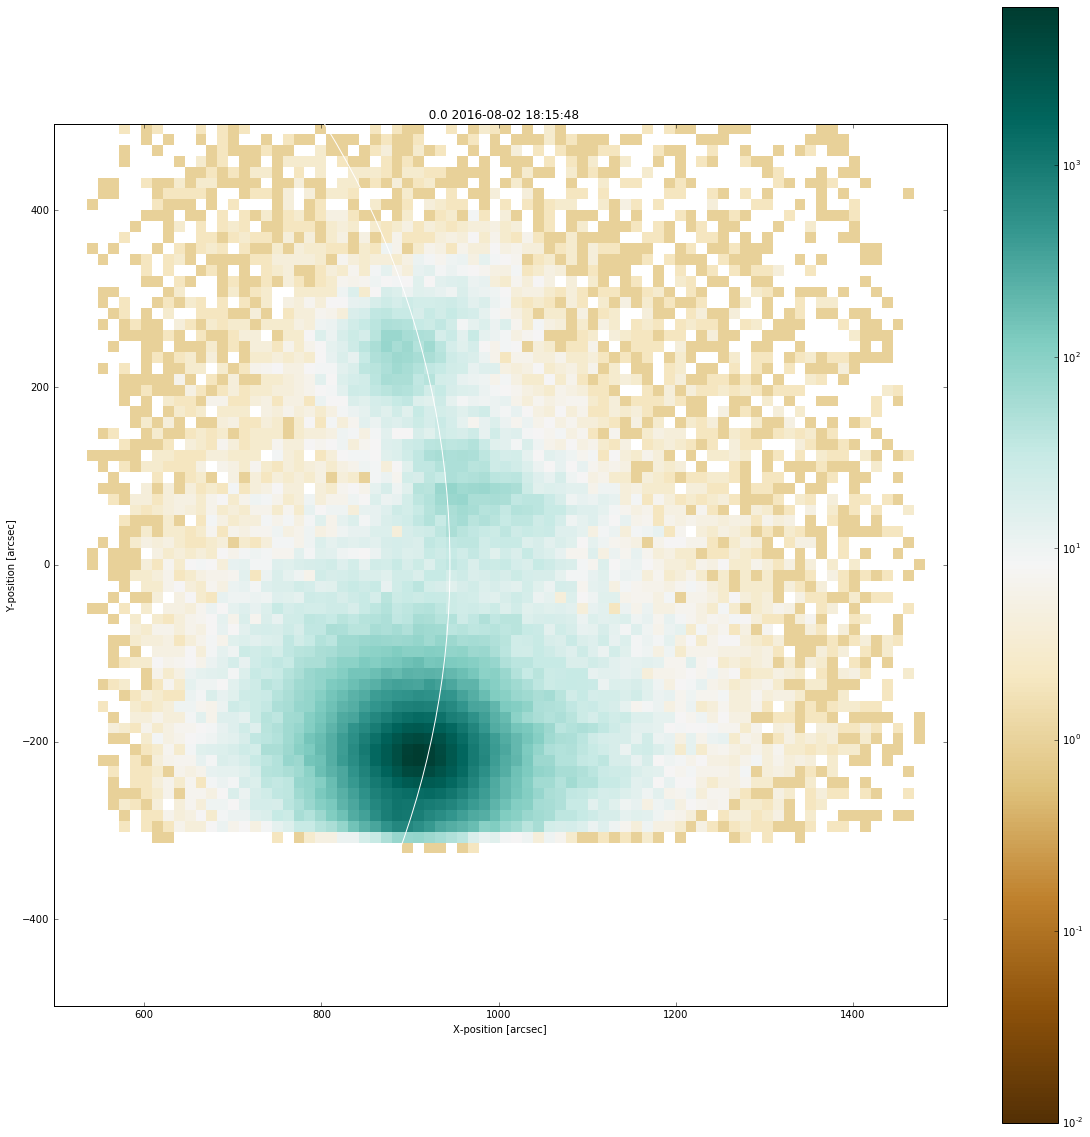

In [184]:
rangex = u.Quantity([500*u.arcsec, 1500 * u.arcsec])
rangey = u.Quantity([-500 * u.arcsec, 500 * u.arcsec])

nustar_submap = nustar_map.submap(rangex, rangey)
plt.subplots(figsize=(20, 20))


nustar_submap.plot()
plt.colorbar()
nustar_submap.draw_limb()
